# Ermittlung des nächsten Wartungszeitpunkts

Dieses Notebook bildet den in der Aufgabenstellung beschriebenen KNIME-Workflow mit Python nach. 

Wir verwenden die Bibliotheken `pandas` zur Datenmanipulation und `scikit-learn` für das maschinelle Lernen.

Tutorial: https://scikit-learn.org/stable/auto_examples/tree/index.html

## 0. Setup

In [324]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from typing import Tuple, List
from pathlib import Path # Import für professionelles Pfad-Management

In [325]:
# Konfiguration

DATA_FOLDER = "data"
FILE_NAME = "Festlegung_Wartung_historisch.xlsx"
DATA_FILE = Path(DATA_FOLDER) / FILE_NAME

TEST_SIZE = 0.2
RANDOM_STATE = 42               # Für reproduzierbare Ergebnisse
MAX_DEPTH = 3

# Matplotlib-Plots direkt im Notebook anzeigen und Theme setzen
%matplotlib inline
sns.set_theme(style="whitegrid")


In [326]:
# Hilfs-Funktionen

def plot_confusion_matrix(y_true: pd.Series, y_pred: np.ndarray, class_names: List[str], title: str):
    """Stellt eine Konfusionsmatrix grafisch dar."""

    cm = confusion_matrix(y_true, y_pred, labels=class_names)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    
    plt.title(title)
    plt.ylabel('Wahre Klasse')
    plt.xlabel('Vorhergesagte Klasse')
    plt.show()

def plot_multiclass_roc(model: DecisionTreeClassifier, X_test: pd.DataFrame, y_test: pd.Series, class_names: List[str]):
    """Stellt die ROC-Kurven für jede Klasse dar (entspricht Schritt 7)."""
    
    y_score = model.predict_proba(X_test)
    y_test_binarized = pd.get_dummies(y_test).reindex(columns=class_names, fill_value=0).values

    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'ROC-Kurve für Klasse "{class_name}" (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Zufälliger Klassifikator')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Spezifität)')
    plt.ylabel('True Positive Rate (Sensitivität)')
    plt.title('Receiver Operating Characteristic (ROC) für Multi-Class')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

## 1. Daten laden 

In [327]:
try:
    df = pd.read_excel(DATA_FILE)
    print(f"Daten erfolgreich geladen: \n{len(df)} Datensätze gefunden.")
except FileNotFoundError:
    print(f"FEHLER: Die Datei '{DATA_FILE}' wurde nicht gefunden. Bitte überprüfen Sie den Pfad.")
    df = None

Daten erfolgreich geladen: 
99 Datensätze gefunden.


## 2. Spalte entfernen

In [328]:
df = df.drop(columns=['Datum der Instandhaltung'])
print(df.columns)

Index(['Maschine', 'Betriebsstunden seit letzter Instandhaltung [h]',
       'Betriebstemperatur des Antriebs [°C]', 'Produktionsauslastung [%]',
       'Vibrationen [Hz]', 'Wie lange bis zur nächsten Wartung?'],
      dtype='object')


## 3. Datensatz erstellen 

In [329]:
X = df.drop(columns=['Wie lange bis zur nächsten Wartung?'])
y = df['Wie lange bis zur nächsten Wartung?']

# One-Hot-Encoding auf X anwenden
X = pd.get_dummies(X, columns=['Maschine'], drop_first=True)

# Eindeutige Klassennamen für spätere Visualisierungen speichern
class_names = sorted(y.unique())

print("\nFeatures (X):")
display(X.head())
print("\nZielvariable (y):")
display(y.head())


Features (X):


,Betriebsstunden seit letzter Instandhaltung [h],Betriebstemperatur des Antriebs [°C],Produktionsauslastung [%],Vibrationen [Hz],Maschine_EMCO MaxxTurn 65,Maschine_Haas ST-20
0,1040,63,78,256,False,False
1,1184,50,68,177,False,True
2,688,51,64,175,True,False
3,656,56,72,270,False,False
4,288,41,75,67,False,True



Zielvariable (y):


0             Heute
1             Heute
2    In einem Monat
3    In einer Woche
4    In einer Woche
Name: Wie lange bis zur nächsten Wartung?, dtype: object

### 3.1 Manuelle Aufteilung (Take from top)

In [330]:
# Manuelle Aufteilung: 80% von oben
split_index = int(len(X) * (1 - TEST_SIZE))
X_train_1, y_train_1 = X[:split_index], y[:split_index]
X_test_1, y_test_1 = X[split_index:], y[split_index:]

print(f"Daten aufgeteilt (Take from top): {len(X_train_1)} Trainingsdaten, {len(X_test_1)} Testdaten.")
print("\nVerteilung der Klassen im Trainingsdatensatz:")
print(y_train_1.value_counts(normalize=True))
print("\nVerteilung der Klassen im Testdatensatz:")
print(y_test_1.value_counts(normalize=True))
print("\n-> ACHTUNG: Die Verteilung der Klassen ist in Trainings- und Testset sehr unterschiedlich! Das ist ein Problem.")

Daten aufgeteilt (Take from top): 79 Trainingsdaten, 20 Testdaten.

Verteilung der Klassen im Trainingsdatensatz:
Wie lange bis zur nächsten Wartung?
In einer Woche       0.405063
In einem Monat       0.341772
In drei Werktagen    0.151899
Heute                0.101266
Name: proportion, dtype: float64

Verteilung der Klassen im Testdatensatz:
Wie lange bis zur nächsten Wartung?
In einer Woche       0.50
In einem Monat       0.20
Heute                0.15
In drei Werktagen    0.15
Name: proportion, dtype: float64

-> ACHTUNG: Die Verteilung der Klassen ist in Trainings- und Testset sehr unterschiedlich! Das ist ein Problem.


### 3.2 Stratified Split

In [331]:
# Verbesserte Aufteilung mit scikit-learn
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    X, y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE, 
    stratify=y # Dies ist der entscheidende Parameter!
)

print(f"Daten aufgeteilt (Stratified): {len(X_train_2)} Trainingsdaten, {len(X_test_2)} Testdaten.")
print("\nVerteilung der Klassen im gesamten Datensatz:")
print(y.value_counts(normalize=True))
print("\nVerteilung der Klassen im Testdatensatz (stratified):")
print(y_test_2.value_counts(normalize=True))
print("\n-> Die Verteilungen sind nun nahezu identisch. Sehr gut!")

Daten aufgeteilt (Stratified): 79 Trainingsdaten, 20 Testdaten.

Verteilung der Klassen im gesamten Datensatz:
Wie lange bis zur nächsten Wartung?
In einer Woche       0.424242
In einem Monat       0.313131
In drei Werktagen    0.151515
Heute                0.111111
Name: proportion, dtype: float64

Verteilung der Klassen im Testdatensatz (stratified):
Wie lange bis zur nächsten Wartung?
In einer Woche       0.45
In einem Monat       0.30
In drei Werktagen    0.15
Heute                0.10
Name: proportion, dtype: float64

-> Die Verteilungen sind nun nahezu identisch. Sehr gut!


## 4. Training

In [332]:
# Modell 1

print("Trainiere Entscheidungsbaum...")
model_1 = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=MAX_DEPTH)
model_1.fit(X_train_1, y_train_1)
y_pred_1 = model_1.predict(X_test_1)
print("Training und Vorhersage abgeschlossen.")


Trainiere Entscheidungsbaum...
Training und Vorhersage abgeschlossen.


In [333]:
# Modell 2

print("Trainiere finalen Entscheidungsbaum...")
model_2 = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=MAX_DEPTH)
model_2.fit(X_train_2, y_train_2)
y_pred_2 = model_2.predict(X_test_2)
print("Training und Vorhersage abgeschlossen.")

Trainiere finalen Entscheidungsbaum...
Training und Vorhersage abgeschlossen.


Durch die einstellung der "max_depth" kann Over fitting gesteuert und vermieden werden.

## 5. Vorhersagen 

In [334]:
# Beispielhafte Vorhersage für einen einzelnen Datenpunkt

# Wir nehmen den ersten Datenpunkt aus dem ursprünglichen Feature-Set X
sample_data = X.iloc[[0]]
print("Beispieldaten für die Vorhersage:")
display(sample_data)

# Vorhersage mit Modell 1
prediction_1 = model_1.predict(sample_data)[0]
print(f"\nVorhersage mit Modell 1: {prediction_1}")

# Vorhersage mit Modell 2
prediction_2 = model_2.predict(sample_data)[0]
print(f"Vorhersage mit Modell 2: {prediction_2}")

Beispieldaten für die Vorhersage:


,Betriebsstunden seit letzter Instandhaltung [h],Betriebstemperatur des Antriebs [°C],Produktionsauslastung [%],Vibrationen [Hz],Maschine_EMCO MaxxTurn 65,Maschine_Haas ST-20
0,1040,63,78,256,False,False



Vorhersage mit Modell 1: Heute
Vorhersage mit Modell 2: Heute


## 6. Bewerten

### 6.1 Modell 1


--- Bewertung Modell 1 ---
Genauigkeit (Accuracy): 80.00%

Classification Report:
                   precision    recall  f1-score   support

            Heute       0.00      0.00      0.00         3
In drei Werktagen       0.75      1.00      0.86         3
   In einem Monat       0.80      1.00      0.89         4
   In einer Woche       0.82      0.90      0.86        10

         accuracy                           0.80        20
        macro avg       0.59      0.72      0.65        20
     weighted avg       0.68      0.80      0.73        20



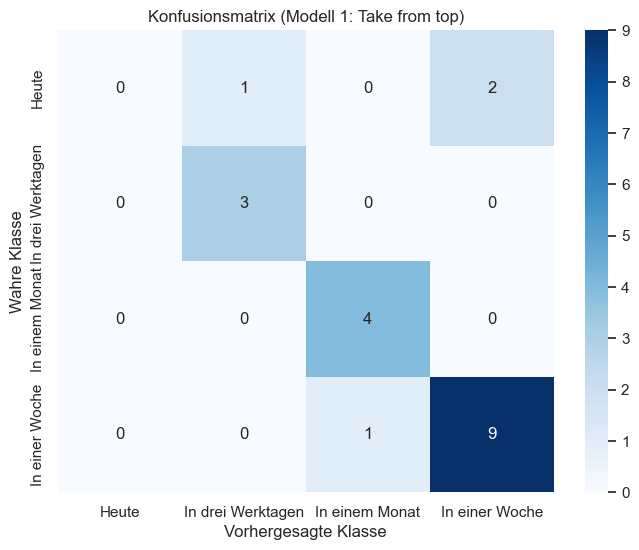

In [335]:
# Bewertung Modell 1

print("\n--- Bewertung Modell 1 ---")
accuracy_1 = accuracy_score(y_test_1, y_pred_1)
print(f"Genauigkeit (Accuracy): {accuracy_1:.2%}")

print("\nClassification Report:")
print(classification_report(y_test_1, y_pred_1, target_names=class_names, zero_division=0))

plot_confusion_matrix(y_test_1, y_pred_1, class_names, title="Konfusionsmatrix (Modell 1: Take from top)")

### 6.2 Modell 2


--- Bewertung Modell 2 (Final) ---
Genauigkeit (Accuracy): 100.00%
Verbesserung der Genauigkeit gegenüber Modell 1: +20.00%

Classification Report:
                   precision    recall  f1-score   support

            Heute       1.00      1.00      1.00         2
In drei Werktagen       1.00      1.00      1.00         3
   In einem Monat       1.00      1.00      1.00         6
   In einer Woche       1.00      1.00      1.00         9

         accuracy                           1.00        20
        macro avg       1.00      1.00      1.00        20
     weighted avg       1.00      1.00      1.00        20



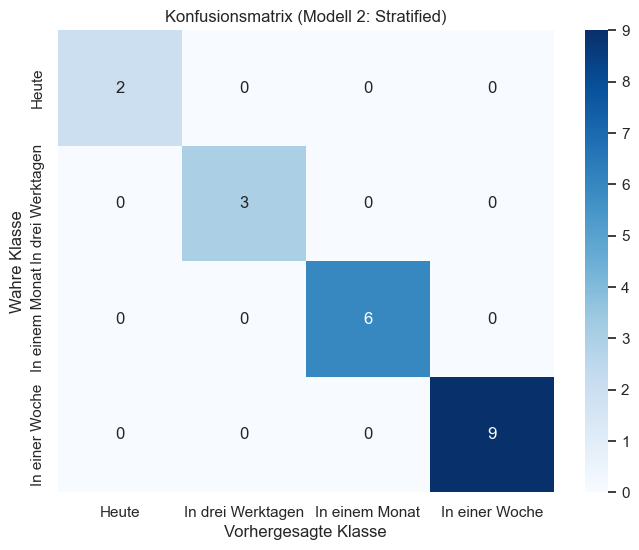

In [336]:
# Bewertung Modell 2

print("\n--- Bewertung Modell 2 (Final) ---")
accuracy_2 = accuracy_score(y_test_2, y_pred_2)
print(f"Genauigkeit (Accuracy): {accuracy_2:.2%}")
print(f"Verbesserung der Genauigkeit gegenüber Modell 1: {accuracy_2 - accuracy_1:+.2%}")

print("\nClassification Report:")
print(classification_report(y_test_2, y_pred_2, target_names=class_names))

plot_confusion_matrix(y_test_2, y_pred_2, class_names, title="Konfusionsmatrix (Modell 2: Stratified)")

Modell 2 ist viel genauer. Das kann direkt an der "Accuracy" und in der Konfusionsmatrix erkannt werden.

## 7. ROC-Kurve 

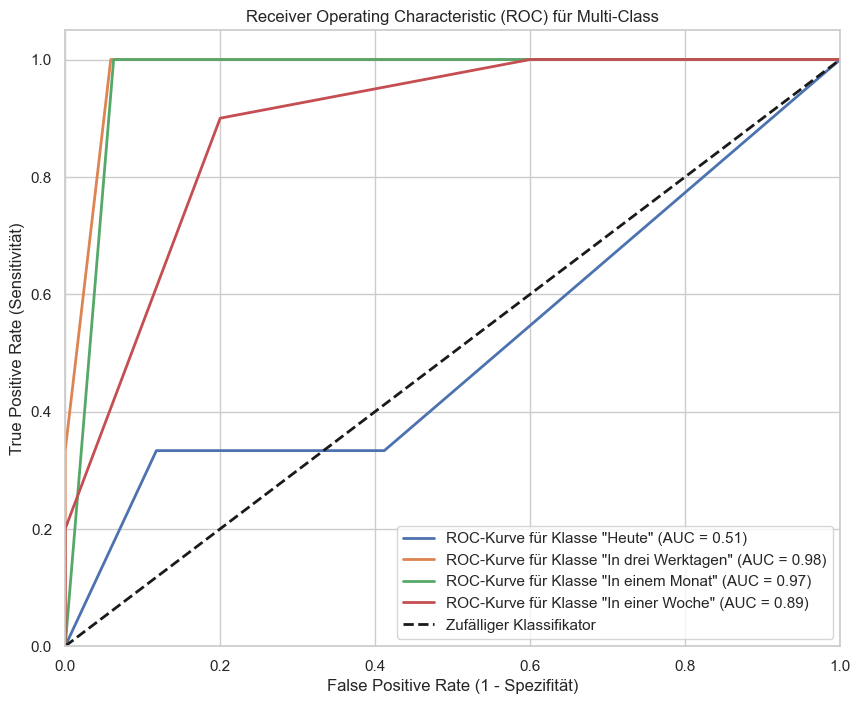

In [337]:
plot_multiclass_roc(model_1, X_test_1, y_test_1, class_names)

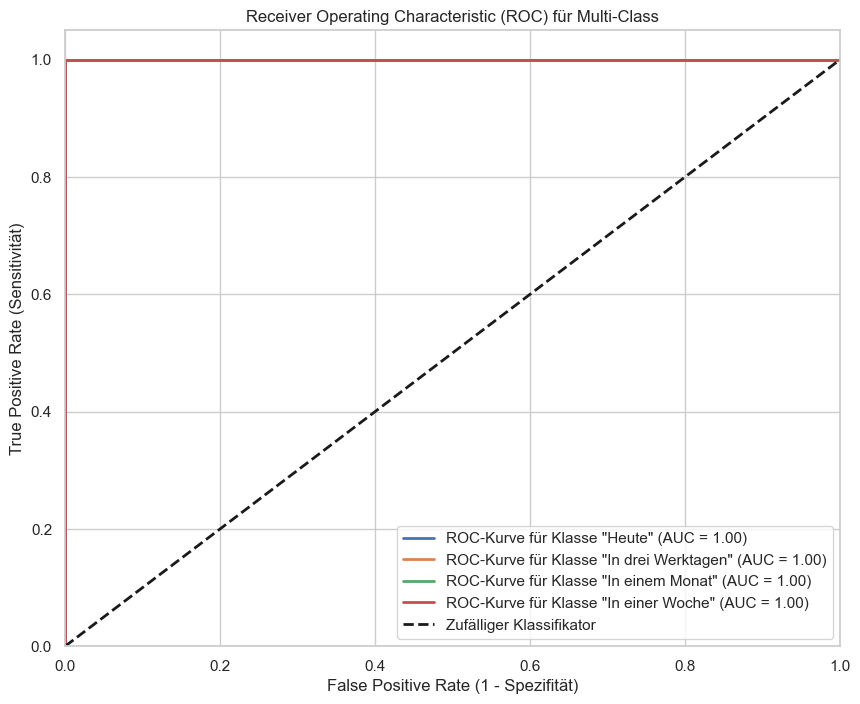

In [338]:
plot_multiclass_roc(model_2, X_test_2, y_test_2, class_names)

## 8. Visualisierung des Entscheidungsbaums (Bonus)

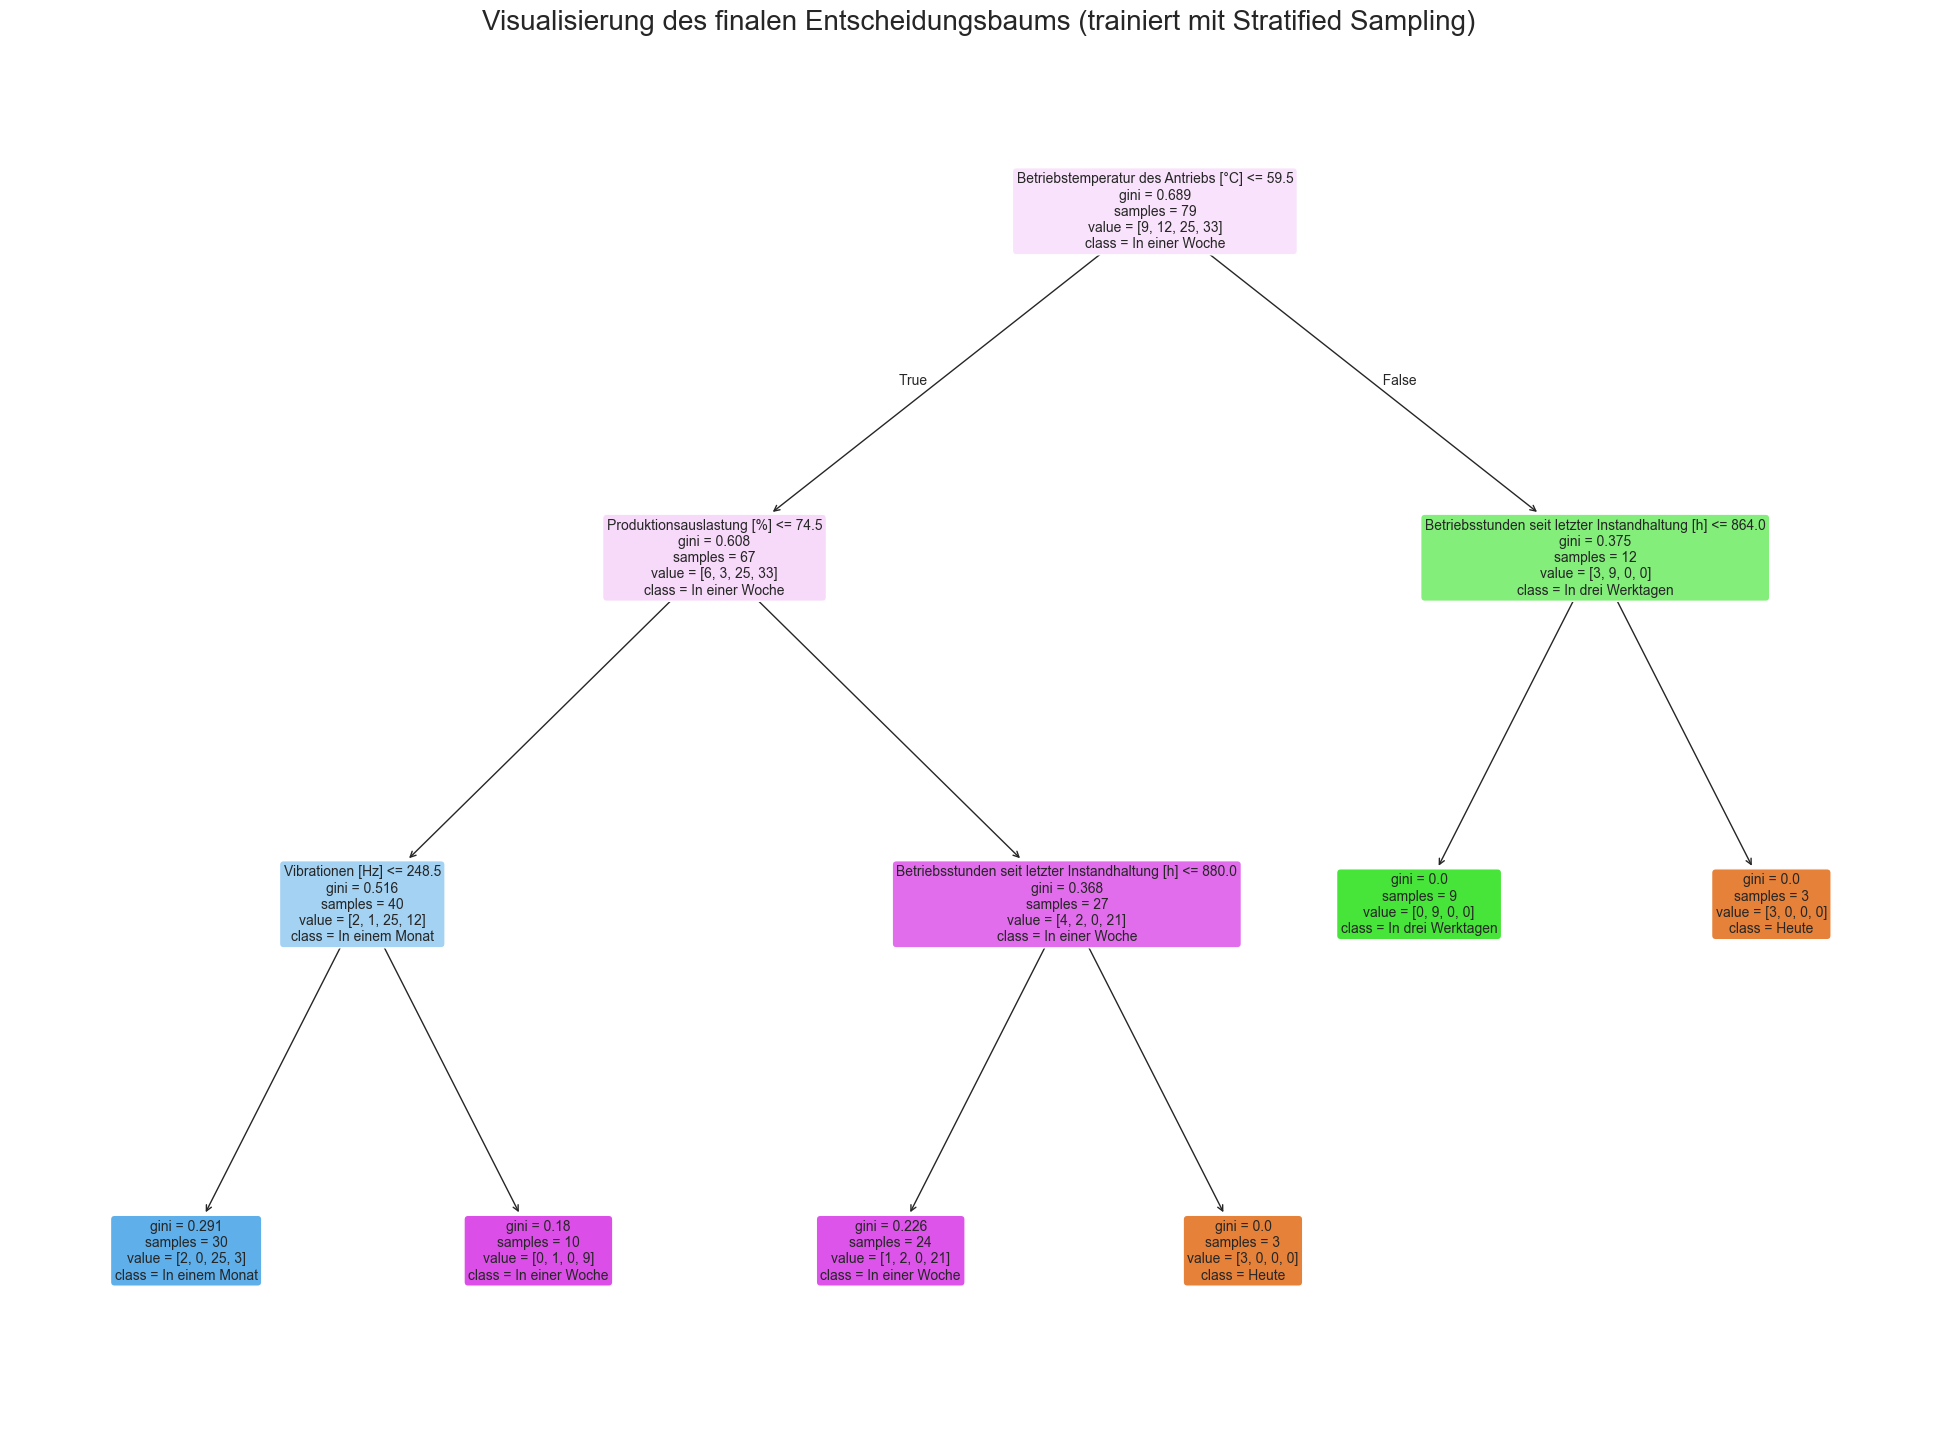

In [339]:
# Visualisierung

plt.figure(figsize=(25, 18))
plot_tree(model_2,
          feature_names=X.columns.tolist(),
          class_names=class_names,
          filled=True,
          rounded=True,
          fontsize=10)
plt.title("Visualisierung des finalen Entscheidungsbaums (trainiert mit Stratified Sampling)", fontsize=20)
plt.show()